In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df_response = pd.read_csv('/content/gdrive/MyDrive/BAD7105-CRM-Analytics/HW04 - Up-selling Analysis and Customer Response Models/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/gdrive/MyDrive/BAD7105-CRM-Analytics/HW04 - Up-selling Analysis and Customer Response Models/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [67]:
df_response

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1
...,...,...
6879,CS8996,0
6880,CS8997,0
6881,CS8998,0
6882,CS8999,0


In [68]:
df_transactions

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0
...,...,...,...,...
124995,CS8433,2011-06-26,64,1360.0
124996,CS7232,2014-08-19,38,210.0
124997,CS8731,2014-11-28,42,109.0
124998,CS8133,2013-12-14,13,458.0


In [10]:
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [71]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary'}, inplace=True)

In [72]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [74]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary'] / df_clv['frequency']

In [75]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


In [15]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


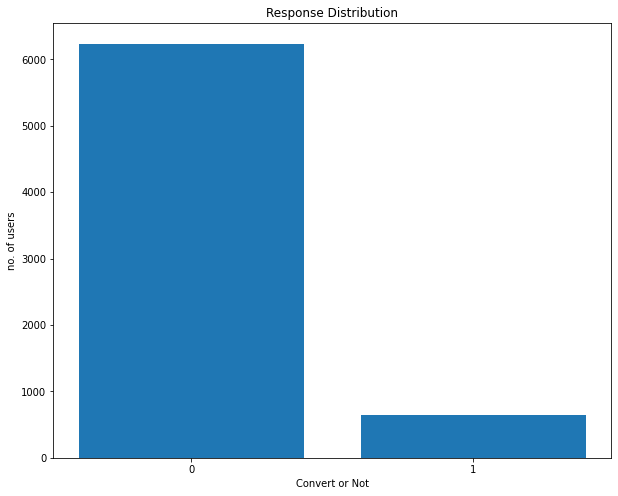

In [78]:
plt.figure(figsize=(10,8))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.savefig('imbalance.png',dpi=300)
plt.show()

## data is imbalanced

In [17]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


In [18]:
## spliting dataframe into X and y
X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [19]:
## creating train and test dataset
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0,stratify=y_clv)

In [21]:
sm = SMOTE(random_state=0)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

In [90]:
model = XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.005,
 n_estimators=600,
 max_depth=4,
 colsample_bytree=0.5)

model.fit(X_SMOTE_clv,y_SMOTE_clv)

y_train_predicted = model.predict(X_SMOTE_clv)
y_test_predicted = model.predict(X_test_clv)

y_score_train = model.predict_proba(X_SMOTE_clv)
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])

y_score_test = model.predict_proba(X_test_clv)
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])

print('auc_train =',auc_train)
print('auc_test =',auc_test)

auc_train = 0.8127722734602673
auc_test = 0.7186949290686404


In [92]:
print('train',classification_report(y_SMOTE_clv,y_train_predicted,digits=3))
print('test',classification_report(y_test_clv,y_test_predicted,digits=3))

train               precision    recall  f1-score   support

           0      0.839     0.595     0.696      4365
           1      0.686     0.886     0.773      4365

    accuracy                          0.741      8730
   macro avg      0.763     0.741     0.735      8730
weighted avg      0.763     0.741     0.735      8730

test               precision    recall  f1-score   support

           0      0.952     0.596     0.733      1872
           1      0.154     0.711     0.254       194

    accuracy                          0.607      2066
   macro avg      0.553     0.654     0.493      2066
weighted avg      0.877     0.607     0.688      2066



auc_train = 0.8127722734602673


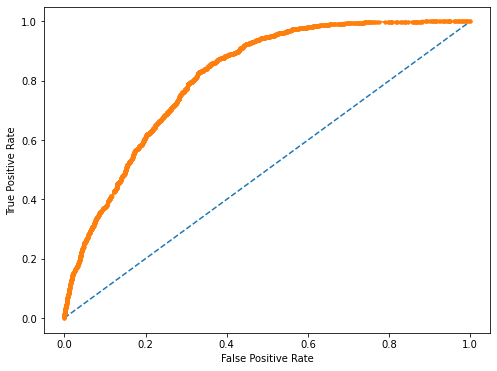

In [96]:
ns_probs = [0 for _ in range(len(y_SMOTE_clv))]

ns_fpr, ns_tpr, _ = roc_curve(y_SMOTE_clv, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])

print('auc_train =',auc_train)
plt.figure(figsize=(8,6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_train.png',dpi=300)
plt.show()

auc_test = 0.7186949290686404


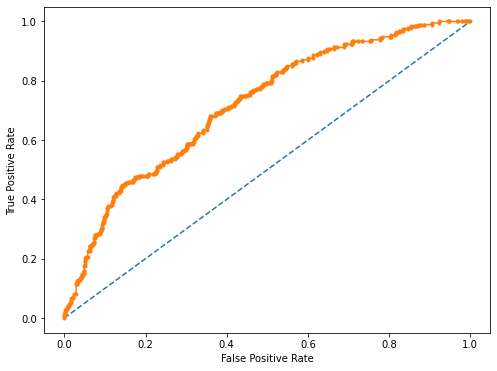

In [95]:
ns_probs = [0 for _ in range(len(y_test_clv))]

ns_fpr, ns_tpr, _ = roc_curve(y_test_clv, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_clv, y_score_test[:,1])

print('auc_test =',auc_test)
plt.figure(figsize=(8,6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_test.png',dpi=300)
plt.show()